# Reading pickle files

## Loading

In [15]:
import pickle

pickle_file_path = '../data/seashell/seashell.pickle'
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

In [16]:
for k, v in data.items():
    print(f'{k} ({v})' if len(str(v)) < 30 else f'{k} ({type(v)})')

mode (cone)
DSD (27687.0)
DSO (10533.0)
nDetector ([560, 560])
sDetector (<class 'list'>)
nVoxel ([256, 256, 256])
sVoxel ([2000.0, 2000.0, 2000.0])
offOrigin ([0.0, 0.0, 0.0])
offDetector ([0.0, 0.0])
accuracy (0.5)
totalAngle (360.0)
startAngle (0.0)
noise (True)
filter (None)
numTrain (25)
numVal (100)
dDetector ([10.0, 10.0])
dVoxel ([7.8125, 7.8125, 7.8125])
train (<class 'dict'>)
val (<class 'dict'>)
image (<class 'numpy.ndarray'>)


In [10]:
data['xyz'].shape # (66823, 3)
data['density'].shape # (66823, 1)
data['scale'].shape # (66823, 3)
data['rotation'].shape # (66823, 4)


(66823, 3)

In [33]:
data['normalize'] = False

## Inspection

In [18]:
data["train"].keys()

dict_keys(['projections', 'angles'])

In [17]:
data["train"]["angles"]

array([0.        , 0.26179939, 0.52359878, 0.78539816, 1.04719755,
       1.30899694, 1.57079633, 1.83259571, 2.0943951 , 2.35619449,
       2.61799388, 2.87979327, 3.14159265, 3.40339204, 3.66519143,
       3.92699082, 4.1887902 , 4.45058959, 4.71238898, 4.97418837,
       5.23598776, 5.49778714, 5.75958653, 6.02138592, 6.28318531])

In [6]:
data["train"]["projections"].shape

(25, 560, 560)

In [7]:
data["train"]["projections"].dtype

dtype('float32')

Global statistics

In [4]:
import numpy as np

projections = data["train"]["projections"]

global_mean = np.mean(projections)
global_std = np.std(projections)
global_median = np.median(projections)
print(f"Global Mean: {global_mean},\nGlobal Std: {global_std},\nGlobal Median: {global_median}")


Global Mean: 0.036182552576065063,
Global Std: 0.049850109964609146,
Global Median: 0.012185315601527691


Per-projection statistics

In [5]:
import matplotlib.pyplot as plt

def plot_statistics(means_per_projection, mins_per_projection, maxs_per_projection, title='Statistics per Projection'):
    plt.figure(figsize=(8, 4))
    plt.plot(means_per_projection, label='Mean', color='blue', marker='o')
    plt.plot(mins_per_projection, label='Min', color='red', marker='x')
    plt.plot(maxs_per_projection, label='Max', color='green', marker='s')

    plt.xlabel('Projection Index')
    plt.ylabel('Pixel Intensity')
    plt.title(title)
    plt.legend()
    plt.grid(True)

    plt.show()

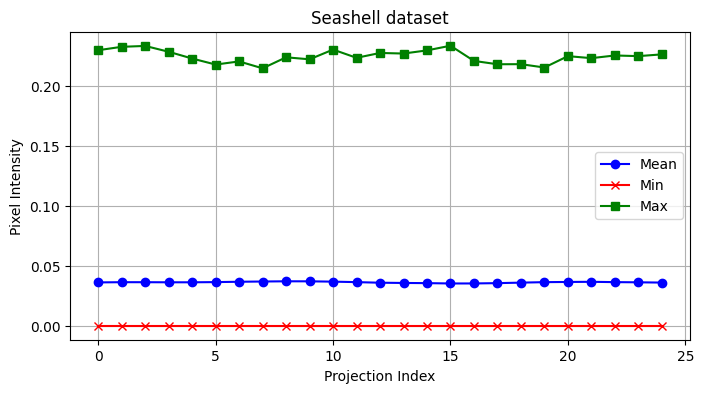

In [6]:
means_per_projection = np.mean(projections, axis=(1, 2))
mins_per_projection = np.min(projections, axis=(1, 2))
maxs_per_projection = np.max(projections, axis=(1, 2))
plot_statistics(means_per_projection, mins_per_projection, maxs_per_projection, title='Seashell dataset')

We normalize the projections and see what happens.

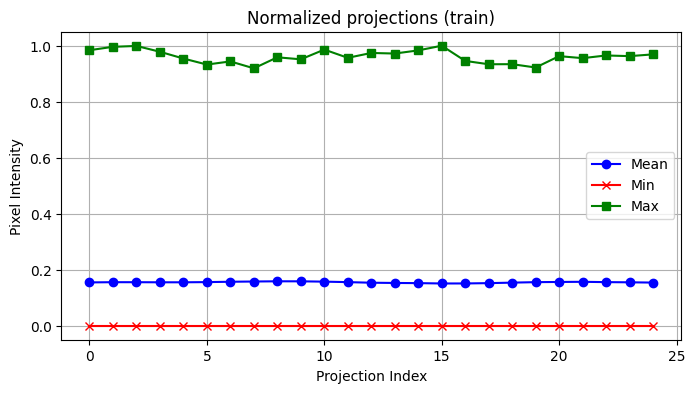

In [14]:
min_val = np.min(projections)
max_val = np.max(projections)
normalized_projections = (projections - min_val) / (max_val - min_val)

means_per_projection = np.mean(normalized_projections, axis=(1, 2))
mins_per_projection = np.min(normalized_projections, axis=(1, 2))
maxs_per_projection = np.max(normalized_projections, axis=(1, 2))
plot_statistics(means_per_projection, mins_per_projection, maxs_per_projection, title='Normalized projections (train)')

Normalized also the projections in the validation set.

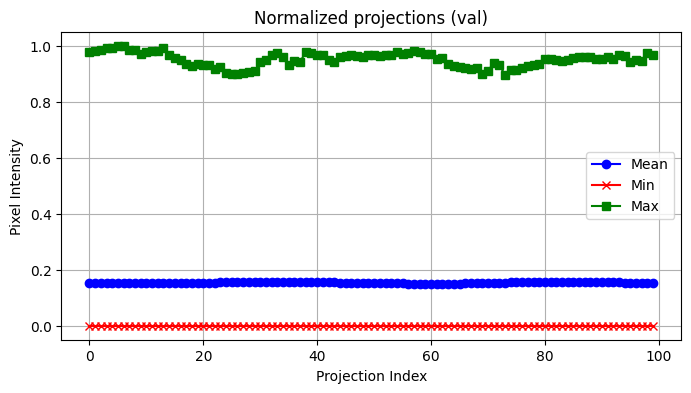

In [15]:
val_projections = data["val"]["projections"]

min_val = np.min(val_projections)
max_val = np.max(val_projections)
normalized_val_projections = (val_projections - min_val) / (max_val - min_val)

means_per_projection = np.mean(normalized_val_projections, axis=(1, 2))
mins_per_projection = np.min(normalized_val_projections, axis=(1, 2))
maxs_per_projection = np.max(normalized_val_projections, axis=(1, 2))
plot_statistics(means_per_projection, mins_per_projection, maxs_per_projection, title='Normalized projections (val)')

Save pikle file with normalized projections.

In [30]:
data["train"]["projections"] = normalized_projections
data["val"]["projections"] = normalized_val_projections

pickle_file = "data/pickle/chest_50_normalized.pickle"
with open(pickle_file, "wb") as f:
    pickle.dump(data, f)

print(f'Saved')

Saved


Save and that's it.

In [35]:
pickle_file = "data/pickle/chest_50_norm_false.pickle"
with open(pickle_file, "wb") as f:
    pickle.dump(data, f)

print(f'Saved')

Saved


Histogram of pixel intensities

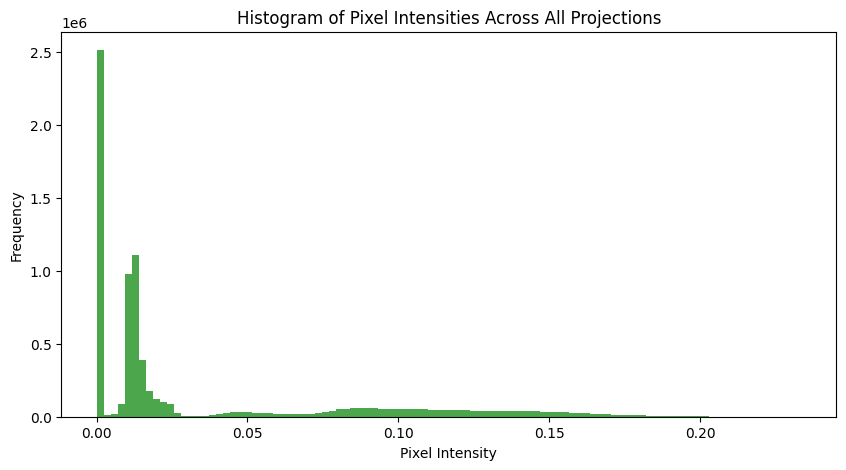

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(projections.ravel(), bins=100, color='green', alpha=0.7, log=False)
plt.title("Histogram of Pixel Intensities Across All Projections")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

Display sample projections

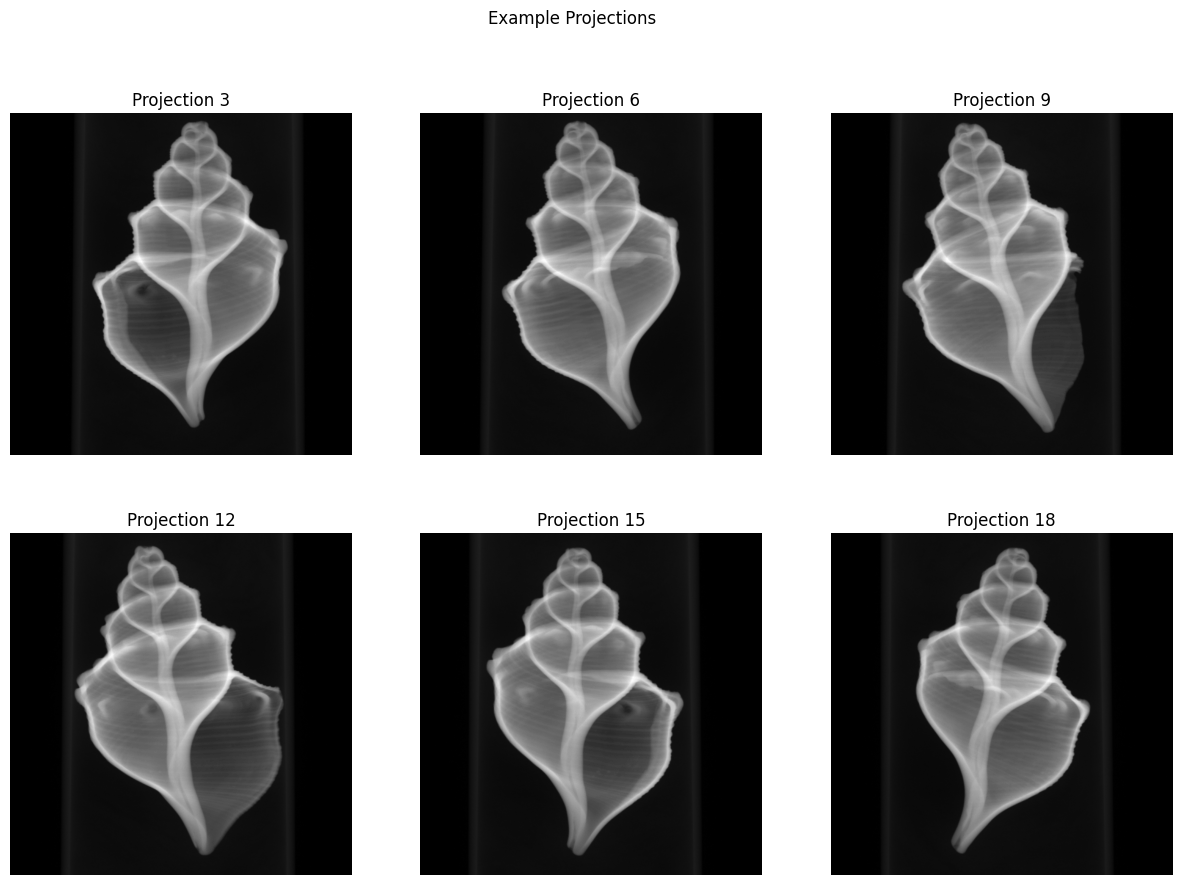

In [19]:
skip_every = 3

plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(projections[skip_every * i], cmap='gray')
    plt.title(f"Projection {skip_every * (i+1)}")
    plt.axis('off')
plt.suptitle("Example Projections")
plt.show()
